__Chapter 7 - Combining different models for ensemble learning__

1. [Import](#Import)
1. [Learning with ensembles](#Learning-with-ensembles)
    1. [Implementing a simple majority vote classifier](#Implementing-a-simple-majority-vote-classifier)
    1. [Homegrown implementation](#Homegrown-implementation-ens)
1. [Bagging – building an ensemble of classifiers from bootstrap samples](#building-an-ensemble-of-classifiers-from-bootstrap-samples)
1. [ Leveraging weak learners via adaptive boosting](#Leveraging-weak-learners-via-adaptive-boosting)
    1. [Homegrown implementation](#Homegrown-implementation-adaboost)


# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from io import StringIO
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.utils as utils

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Learning with ensembles

An ensemble is a meta-classifier that consists of several different models tuned trained on a problem. Rather than evaluating the performance of one model on its own, an ensemble enlists all models to evaluate the test data and predictions are made based on majority voting. The aim is to achieve better generalization through all models being used simultaneously.

For binary class labels, majority vote among the ensemble methods determines the prediction. For multi-class labels, plurality (the most votes, or mode) determines the prediction.

$$
\hat{y} = mode\{C_1(x), C_2(x),...,C_m(x)\}
$$

where $C_i$ is one of $m$ distinct models, and each makes a prediction for obseration $x$.

<a id = 'Learning-with-ensembles'></a>

## Implementing a simple majority vote classifier

It's possible to implement a majority vote classifier where each model has an associated weight pertaining to our confidence in that model.

$$
\hat{y} = \mbox{arg max}\sum_{j=1}^{m}w_j\chi_A(C_j(x)=i)
$$

$w_j$ is the weight associated with model $C_j$, $\hat{y}$ is the predicted class label of the whole ensemble, $\chi_A$ is the characteristic function $[C_j(x)=i\in A]$, and $A$ is the set containing the unique class labels. If all model weights are equal, then the equation is effectively the same as the 'mode' function above.

As an example, we have 3 base classifiers and we're predicting the class label of a single instance $\textbf{x}$. $C_1$ and $C_2$ predict class 0, and $C_3$ predicts class 1. Under equal weighting:

$$
\hat{y} = mode\{0,0,1\} = 0
$$

Now let's model $C_3$ a weight of 0.6 and models $C_1$ and $C_2$ weights of 0.2

$$
\hat{y} = \mbox{arg max} [0.2 \times i_0 + 0.2 \times i_0 + 0.6 \times i_i] = 1
$$

<a id = 'Implementing-a-simple-majority-vote-classifier'></a>

In [2]:
# simple weighting example
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

Additionally, ensembles can consider probabilities associated with predicted class labels returned by predict_probas.

$$
\hat{y} = \mbox{arg max}\sum_{j=1}^{m}w_jp_{ij}
$$

where $p_{ij}$ is the predicted probability of the $j$th classifier for class label $i$.

Let's again use our example where we have a binary classification problem with labels $i = \{0,1\}$ and an ensembles of three classifiers $C_j(j = \{0,1,2\})$. Suppose one sample $\textbf{x}$ return the following probablities for each of the 3 classifiers:

$$
C_1(x) \rightarrow [0.9,0.1], C_2(x) \rightarrow [0.8,0.2], C_3(x) \rightarrow [0.4,0.4 ],
$$

The individual class probabilities are then calculated as:
$$
p(i_0|\textbf{x}) = 0.2 \times 0.9 + 0.2 \times 0.8 + 0.6 \times 0.4 = 0.58
$$
$$
p(i_1|\textbf{x}) = 0.2 \times 0.1 + 0.2 \times 0.2 + 0.6 \times 0.6 = 0.42
$$
$$
\hat{y} = \mbox{arg max} [p(i_0|\textbf{x}),p(i_1|\textbf{x})] = 0
$$

In [3]:
# weighting with probabilities
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
print(np.argmax(p))

[0.58 0.42]
0


## Homegrown implementation

<a id = 'Homegrown-implementation-ens'></a>

In [4]:
# custom majority vote classifier
import sklearn.externals as externals
import operator
import six


class MajorityVoteClassifier(base.BaseEstimator, base.ClassifierMixin):
    def __init__(self, classifiers, vote="classlabel", weights=None):
        """
        Info:
            Description:
                Classifier for performing ensemble majority vote.
            Parameters:
                classifiers : array
                    Classifier of the ensemble
                vote : str
                    Voting type, class label mode or weighted probabilities
                weights : array
                    Weights for weighting class selections or probabilities
        """
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key, value in pipeline._name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """
        Info:
            Description:
                Fit classifiers.
            Parameters:
                X : array
                    Training data
                y : array
                    Labels for training data
        """
        self.lablenc_ = preprocessing.LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = base.clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """
        Info:
            Description:
                Generate predictions for X.
            Parameters:
                X : array
                    Training data
        """
        if self.vote == "probability":
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in clf.classifiers_]).T

            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1,
                arr=predictions,
            )
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            return maj_vote

    def predict_proba(self, X):
        """
        Info:
            Description:
                Predict class probabilities for X.
            Parameters:
                X : array
                    Training data
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """
        Info:
            Description:
                Get classifier parameter names for GridSearch.
            Parameters:
                deep : boolean, default = True
        """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out["{:s}__{:s}".format(name, key)] = value
            return out

In [5]:
# import iris dataset
iris = datasets.load_iris()
df = pd.DataFrame(
    np.c_[iris["data"], iris["target"]], columns=iris["feature_names"] + ["target"]
)

# trim iris data set down to two classes and two features
df = df.iloc[50:, [1, 2, 4]]

In [6]:
# encode label, stratify train test 50/50 split
X, y = df.iloc[:, :2].values, df.iloc[:, -1].values
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.5, random_state=1, stratify=y
)

 Train thee different classifiers and evaluate using 10-fold CV:
 
 - Logistic regression classifier
 - Decision tree classifier
 - k-nearest neighbors

In [7]:
# create separate classifiers
clf1 = linear_model.LogisticRegression(penalty="l2", C=0.001, random_state=1)
clf2 = tree.DecisionTreeClassifier(max_depth=1, criterion="entropy", random_state=0)
clf3 = neighbors.KNeighborsClassifier(n_neighbors=1, p=2, metric="minkowski")
pipe1 = pipeline.Pipeline([["sc", preprocessing.StandardScaler()], ["clf", clf1]])
pipe3 = pipeline.Pipeline([["sc", preprocessing.StandardScaler()], ["clf", clf3]])

clf_labels = ["Logistic regression", "Decision tree", "KNN"]

# cross-validation
print("10-fold CV: \n")
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = model_selection.cross_val_score(
        estimator=clf, X=X_train, y=y_train, cv=10, scoring="roc_auc"
    )
    print(
        "ROC AUC: {:.3f} (+/- {:.3f}) [{:s}]".format(scores.mean(), scores.std(), label)
    )

10-fold CV: 

ROC AUC: 0.872 (+/- 0.172) [Logistic regression]
ROC AUC: 0.892 (+/- 0.158) [Decision tree]
ROC AUC: 0.883 (+/- 0.145) [KNN]


In [8]:
# evlaute using MajorityVoteClassifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ["Majority voting"]
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = model_selection.cross_val_score(
        estimator=clf, X=X_train, y=y_train, cv=10, scoring="roc_auc"
    )
    print(
        "Accuracy: {:.3f} (+/- {:.3f}) [{:s}]".format(
            scores.mean(), scores.std(), label
        )
    )

Accuracy: 0.872 (+/- 0.172) [Logistic regression]
Accuracy: 0.892 (+/- 0.158) [Decision tree]
Accuracy: 0.883 (+/- 0.145) [KNN]
Accuracy: 0.944 (+/- 0.134) [Majority voting]


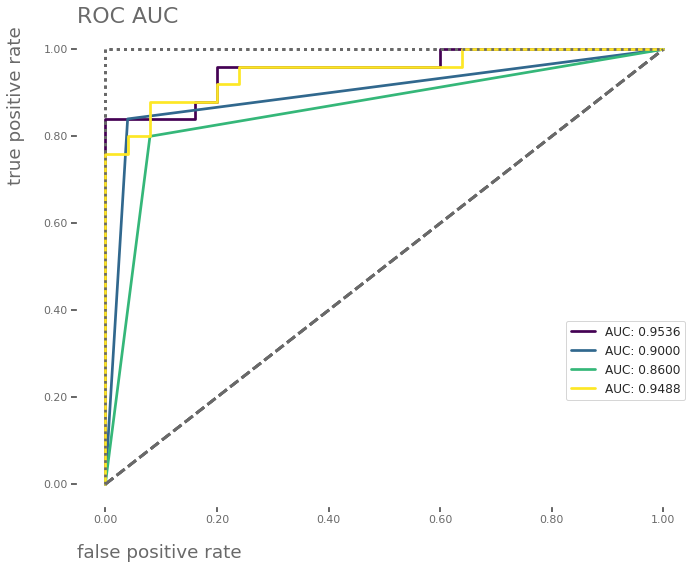

In [9]:
# visualize ROC curve for each model using test set
p = PrettierPlot(chart_prop=11, plot_orientation="square")
ax = p.make_canvas(
    title="ROC AUC",
    xLabel="false positive rate",
    yLabel="true positive rate",
    y_shift=0.67,
)

# colors
colorList = style.colorGen(num=len(clf_labels))
for ix, (clf, label) in enumerate(zip(all_clf, clf_labels)):
    p.pretty_roc_curve(
        model=clf,
        X_train=X_train,
        y_train=y_train,
        X_valid=X_test,
        yValid=y_test,
        linecolor=colorList[ix],
        ax=ax,
    )

> Remarks - The logistic regresion and MajorityVoteClassifier perform similarly. The author attributes this to high variance due to sensitiveity in how we train/test split the small dataset.

In [10]:
# tune the max tree depth fo the decision tree and C for logistic regression
params = {
    "decisiontreeclassifier__max_depth": [1, 2],
    "pipeline-1__clf__C": [0.001, 0.1, 100.0],
}
gs = model_selection.GridSearchCV(
    estimator=mv_clf, param_grid=params, cv=10, scoring="roc_auc"
)
gs.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                                                    steps=[('sc',
                                                                            StandardScaler(copy=True,
                                                                                           with_mean=True,
                                                                                           with_std=True)),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               class_weight=None,
                                                                                               dual=False,
                                                           

In [11]:
# review mean scores, score standard deviations, and parameters
print(gs.cv_results_["mean_test_score"])
print(gs.cv_results_["std_test_score"])
print(gs.cv_results_["params"])

[0.93333333 0.94666667 0.97333333 0.94666667 0.94666667 0.97333333]
[0.14401646 0.14442735 0.07221367 0.14442735 0.14442735 0.07221367]
[{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}, {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}, {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}, {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}, {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}, {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}]


> Remarks - The best CV score of 0.973 occurs twice. In each model, the logistic regression pipeline performs best with C = 100, and the decision tree classifer depth does not seem to make a difference. A max_depth = 2 does not outperform max_depth = 1.

# Bagging – building an ensemble of classifiers from bootstrap samples

Bagging is similar to ensembles in that multiple models are trained. The key difference is rather than using the same training set to fit the individual classifiers, we instead draw boostrap samples (random samples with replacement) from the initial training data. Bagging is also called bootstrap aggregating.

The boostrap samples are typically used to train an unpruned decision tree. Subsequent predictions are decided by majority voting. The Random Forest is an example of a bagging algorithm which uses boostrap examples, and this algorithm also uses a random subset of features in each tree.

<a id = 'building-an-ensemble-of-classifiers-from-bootstrap-samples'></a>

In [12]:
# load and inspect data
df_wine = pd.read_csv("s3://tdp-ml-datasets/misc/wine.data", header=None)

df_wine.columns = [
    "Class label",
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline",
]
df_wine = df_wine[df_wine["Class label"] != 1]
y = df_wine["Class label"].values
X = df_wine[["Alcohol", "OD280/OD315 of diluted wines"]].values

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

In [13]:
df_wine

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
59,2,12.370000,0.940000,1.360000,10.600000,88,1.980000,0.570000,0.280000,0.420000,1.950000,1.050000,1.820000,520
60,2,12.330000,1.100000,2.280000,16.000000,101,2.050000,1.090000,0.630000,0.410000,3.270000,1.250000,1.670000,680
61,2,12.640000,1.360000,2.020000,16.800000,100,2.020000,1.410000,0.530000,0.620000,5.750000,0.980000,1.590000,450
62,2,13.670000,1.250000,1.920000,18.000000,94,2.100000,1.790000,0.320000,0.730000,3.800000,1.230000,2.460000,630
63,2,12.370000,1.130000,2.160000,19.000000,87,3.500000,3.100000,0.190000,1.870000,4.450000,1.220000,2.870000,420
64,2,12.170000,1.450000,2.530000,19.000000,104,1.890000,1.750000,0.450000,1.030000,2.950000,1.450000,2.230000,355
65,2,12.370000,1.210000,2.560000,18.100000,98,2.420000,2.650000,0.370000,2.080000,4.600000,1.190000,2.300000,678
66,2,13.110000,1.010000,1.700000,15.000000,78,2.980000,3.180000,0.260000,2.280000,5.300000,1.120000,3.180000,502
67,2,12.370000,1.170000,1.920000,19.600000,78,2.110000,2.000000,0.270000,1.040000,4.680000,1.120000,3.480000,510
68,2,13.340000,0.940000,2.360000,17.000000,110,2.530000,1.300000,0.550000,0.420000,3.170000,1.020000,1.930000,750


In [14]:
# fit a basic decision tree classifier and a random forest
decTree = tree.DecisionTreeClassifier(
    criterion="entropy", random_state=1, max_depth=None
)
bagTree = ensemble.BaggingClassifier(
    base_estimator=decTree,
    n_estimators=500,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=1,
    random_state=1,
)

In [15]:
# unpruned decision tree
decTree = decTree.fit(X_train, y_train)
yPredTrain = decTree.predict(X_train)
yPredTest = decTree.predict(X_test)
treeTrainAcc = metrics.accuracy_score(y_train, yPredTrain)
treeTestAcc = metrics.accuracy_score(y_test, yPredTest)
print(
    "Decision tree train/test accuracies {:.5f}/ {:.5f}".format(
        treeTrainAcc, treeTestAcc
    )
)

Decision tree train/test accuracies 1.00000/ 0.83333


In [16]:
# bagging ensemble of decision trees
bag = bagTree.fit(X_train, y_train)
yPredTrain = bag.predict(X_train)
yPredTest = bag.predict(X_test)
bagTrainAcc = metrics.accuracy_score(y_train, yPredTrain)
bagTestAcc = metrics.accuracy_score(y_test, yPredTest)
print("Bagging train/test accuracies {:.5f}/ {:.5f}".format(bagTrainAcc, bagTestAcc))

Bagging train/test accuracies 1.00000/ 0.91667


> Remarks - Both classifiers achieve 100% accuracy on the training dataset, but the ensemble achieves better accuracy on the test set. This increased performance is especially pronounced when applied to problems with high dimensionality. In general, bagging is an effective technique for reducing variance, but will not reduce bias. If the features of a dataset cannot explain a model, no amount of trees in an ensemble will be able to perform well.

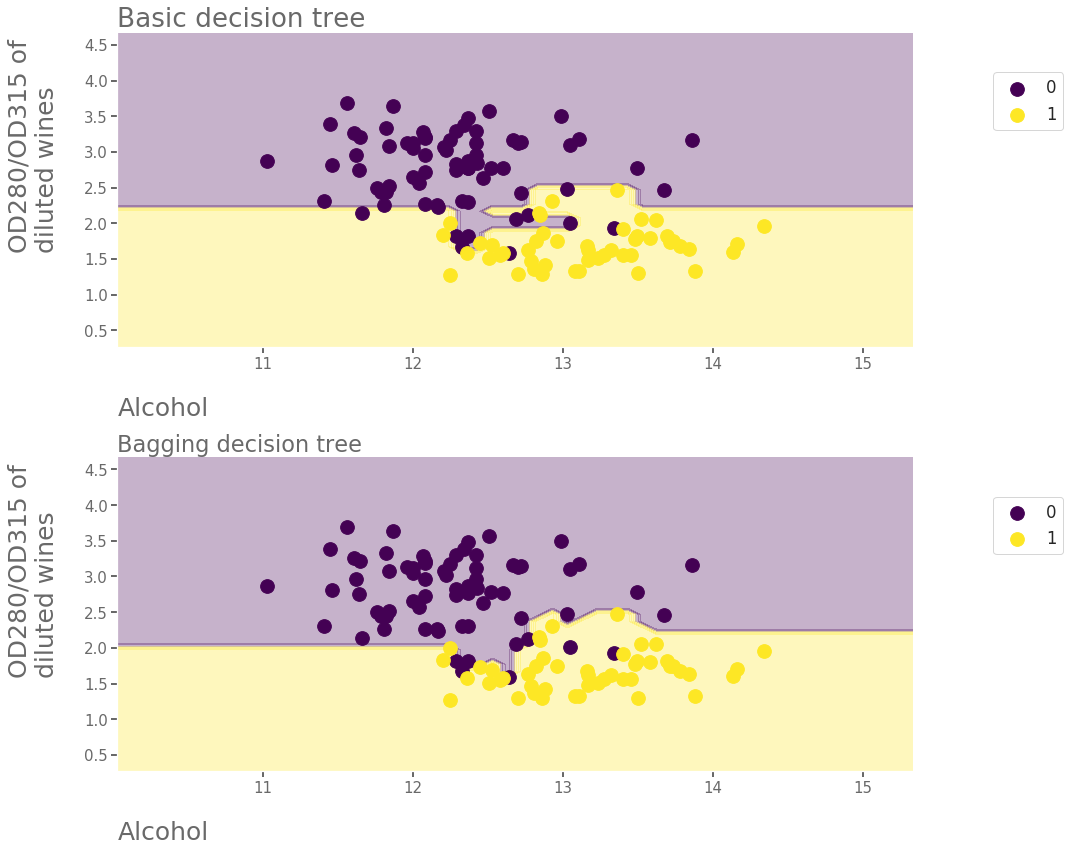

In [17]:
# visualize differeing decision regions
p = PrettierPlot(plot_orientation="square")
ax = p.make_canvas(
    title="Basic decision tree",
    xLabel="Alcohol",
    yLabel="OD280/OD315 of \ndiluted wines",
    y_shift=0.3,
    position=211,
)
p.pretty_decision_region(x=X, y=y, classifier=decTree, testIdx="", bbox=(1.2, 0.9), ax=ax)

ax = p.make_canvas(
    title="Bagging decision tree",
    xLabel="Alcohol",
    yLabel="OD280/OD315 of \ndiluted wines",
    y_shift=0.3,
    position=212,
)
p.pretty_decision_region(x=X, y=y, classifier=bagTree, testIdx="", bbox=(1.2, 0.9), ax=ax)

# Leveraging weak learners via adaptive boosting

Boosting involves an ensemble of very simple base clsasifiers, referred to as weak learning. Each one often only has a slight performance advantage over random guessing. The key focus is of boosting is to focus on samples that are hard to classify. Weaker learners gradually added to the ensemble intend to learn from misclassifications rendered by previous learnings.

__How it works__

The original boosting procedure follows this general framework:

1. Draw a random subset of training samples $d_1$ without replacement from training set $D$ to train a weak learner $C_1$
2. Draw a second random subset of training samples $d_2$ without replacement from the training set $D$ and add 50 percent of the samples that were previously misclassified to train weak learner $C_2$
3. Find the training $d_3$ in training set $D$ which $C_1$ and $C_2$ disagree upon to train a third weak learner, $C_3$
4. Combine the weak learners $C_1$, $C_2$ and $C_3$ via majority learning.

While bagging can decrease variance without decreasing bias, boosting can decrease both variance and bias. 

__AdaBoost__

AdaBoost contrasts to the procedure above in that AdaBoost uses the complete training set to train the weak learners, and the training samples are reweighted in each iteration so that new weak learners can learn from the mistakes of the prior weak learnings. If samples are misclassified in the previous step, those samples are assigned a higher weight for the next weak learner. Further, the correct samples are assigned a lower weight. This results in the next weak learner placing special emphasis on the hard-to-classify samples. In pseudo code:

1. Set the weight vector $\textbf{w}$ to uniform weights, where $\sum_iw_i = 1$
2. For $j$ in $m$ boosting rounds:
    
    a. Train a weighted weak learner $C_J = \mbox{train}(\textbf{X},\textbf{y},\textbf{w})$
    
    b. Predict class labels: $\hat{y} = \mbox{train}(C_j, \textbf{X})$
    
    c. Compute weighted error rate: $\epsilon = \textbf{w} \cdot (\hat{\textbf{y}} \neq \textbf{y}) $
    
    d. Compute coefficient: $\alpha_j = 0.5\mbox{log}\frac{1 - \epsilon}{\epsilon}$
    
    e. Update weights:  $\textbf{w} := \textbf{w} \times \mbox{exp}(-\alpha_j \times \hat{\textbf{y}} \times \textbf{y})$
    
    f. Normalize weights to sum to 1: $\textbf{w} := \textbf{w} / \sum_iw_i$

3. Compute final prediction: $\hat{\textbf{y}} = \big( \sum^m_{j=1}\big( \mathbf{\alpha}_j \times \mbox{predict}(C_j, \textbf{X}) \big) >0\big)$
    
The expression $(\hat{\textbf{y}} \neq \textbf{y})$ refers to a binary vector consisting of 1s and 0s, where 1 = incorrect prediction and 0 is assigned otherwise.

<a id = 'Leveraging-weak-learners-via-adaptive-boosting'></a>

## Homegrown implementation

<a id = 'Homegrown-implementation-adaboost'></a>

In [18]:
# compare a basic decision tree and an AdaBoostClassifier
decTree = tree.DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=1)
ada = ensemble.AdaBoostClassifier(
    base_estimator=decTree, n_estimators=500, learning_rate=1, random_state=1
)

In [19]:
# decision tree stump
decTree = decTree.fit(X_train, y_train)
yPredTrain = decTree.predict(X_train)
yPredTest = decTree.predict(X_test)
treeTrainAcc = metrics.accuracy_score(y_train, yPredTrain)
treeTestAcc = metrics.accuracy_score(y_test, yPredTest)
print(
    "Decision tree train/test accuracies {:.5f}/ {:.5f}".format(
        treeTrainAcc, treeTestAcc
    )
)

Decision tree train/test accuracies 0.91579/ 0.87500


In [20]:
# AdaBoostClassifier ensemble
ada = ada.fit(X_train, y_train)
yPredTrain = ada.predict(X_train)
yPredTest = ada.predict(X_test)
adaTrainAcc = metrics.accuracy_score(y_train, yPredTrain)
adaTestAcc = metrics.accuracy_score(y_test, yPredTest)
print(
    "Decision tree train/test accuracies {:.5f}/ {:.5f}".format(adaTrainAcc, adaTestAcc)
)

Decision tree train/test accuracies 1.00000/ 0.91667


> Remarks - The decision tree stump underfits compared to the unpruned decision tree above. The AdaBoostClassifier identifies all training exmaples correctly and performs better on the training data compared to the decision tree stump. The higher gap between the training and test data on the boosted classifier indicates an increase in variance created by its attempted to reduce the model boas.

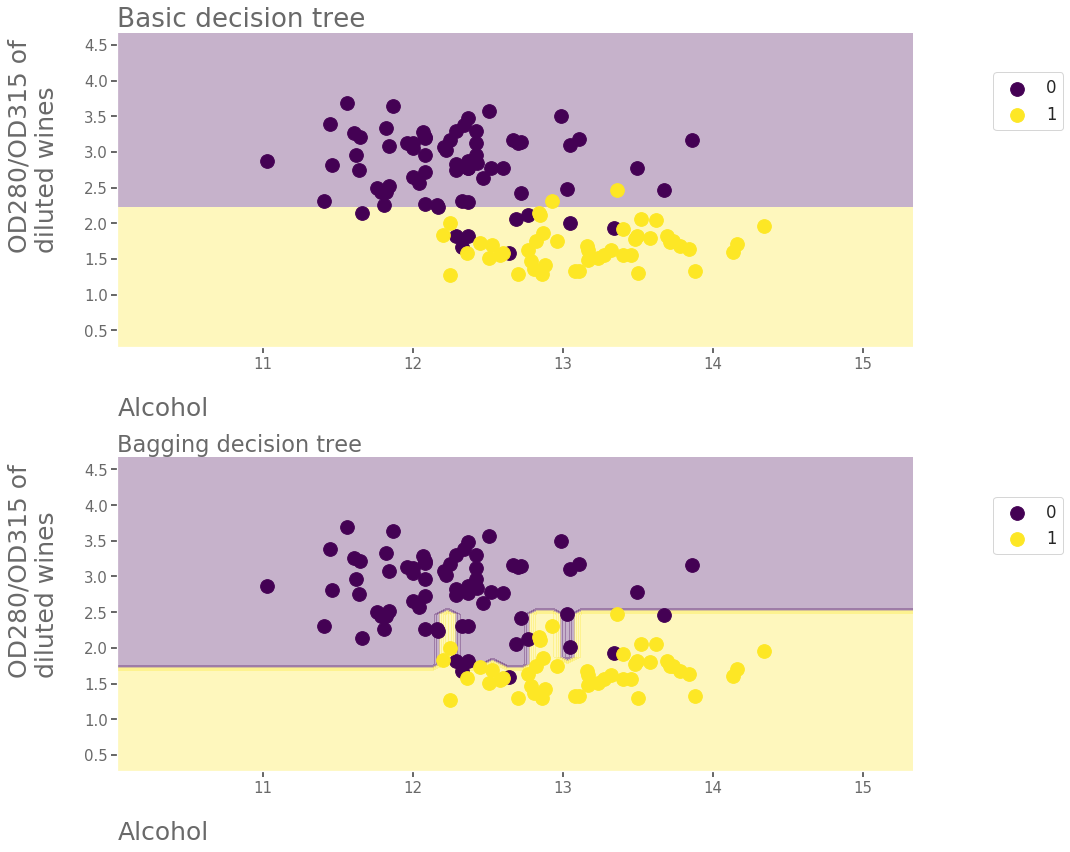

In [21]:
# visualize differeing decision regions
p = PrettierPlot(plot_orientation="square")
ax = p.make_canvas(
    title="Basic decision tree",
    xLabel="Alcohol",
    yLabel="OD280/OD315 of \ndiluted wines",
    y_shift=0.3,
    position=211,
)
p.pretty_decision_region(x=X, y=y, classifier=decTree, testIdx="", bbox=(1.2, 0.9), ax=ax)

ax = p.make_canvas(
    title="Bagging decision tree",
    xLabel="Alcohol",
    yLabel="OD280/OD315 of \ndiluted wines",
    y_shift=0.3,
    position=212,
)
p.pretty_decision_region(x=X, y=y, classifier=ada, testIdx="", bbox=(1.2, 0.9), ax=ax)

> Remarks - It's clear that the decision tree boundary for the AdaBoostClassifier is much more complex than the decision tree stump.